In [46]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer
from tensorflow.keras.utils import to_categorical
import pickle
import warnings
warnings.filterwarnings("ignore")

In [47]:
reviews = pd.read_csv('preprocessed.csv')
reviews.head()

,Text,Score
0,bought several vitality canned dog food produc...,1
1,product arrived labeled jumbo salted peanuts p...,0
2,confection around centuries light pillowy citr...,1
3,looking secret ingredient robitussin believe f...,0
4,great taffy great price wide assortment yummy ...,1


In [48]:
# Check if there are any null values in each column
reviews.isna().any()

Text      True
Score    False
dtype: bool

In [49]:
# Drop any rows from the 'reviews' DataFrame that contain missing (NaN) values.
reviews.dropna(axis=0,inplace=True)

In [50]:
# Check if there are any null values in each column
reviews.isna().any()

Text     False
Score    False
dtype: bool

In [52]:
# Randomly sample 100,000 rows from the 'reviews' DataFrame,
reviews_sample = reviews.sample(100000,random_state=42).reset_index(drop=True)
reviews_sample.head()

,Text,Score
0,tried ine beets bannans peter rabbits squash o...,1
1,love cake mix mixes well incredible amazon off...,1
2,best k cup found hands rich bold deep flavor a...,1
3,new favorite always fan salt vinegar honey dij...,1
4,product win win win healthy snack dog affordab...,1


In [53]:
reviews_sample.shape

(100000, 2)

In [54]:
# Split the dataset into train and test in the ratio of 80:20 respectively.
reviews_train,reviews_test = train_test_split(reviews_sample,test_size=0.20, stratify = reviews_sample['Score'],
                                              random_state=33)

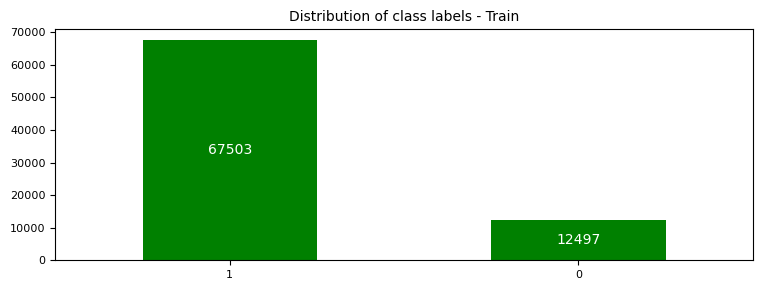

In [55]:
# Plot bar graphs of train and test label distributions
plt.figure(figsize=(9,3))
ax = reviews_train['Score'].value_counts().plot(kind='bar',color='green')
plt.xticks(size=8,rotation=0)
plt.yticks(size=8)

for container in ax.containers:
    ax.bar_label(container,label_type='center',color='white')
plt.title('Distribution of class labels - Train',size=10)    
plt.show()

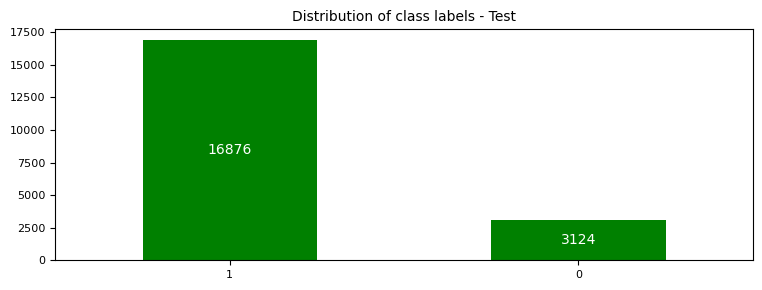

In [56]:
plt.figure(figsize=(9,3))
ax = reviews_test['Score'].value_counts().plot(kind='bar',color='green')
plt.xticks(size=8,rotation=0)
plt.yticks(size=8)

for container in ax.containers:
    ax.bar_label(container,label_type='center',color='white')
plt.title('Distribution of class labels - Test',size=10)    
plt.show()

In [57]:
X_train,y_train = np.array(reviews_train['Text']), np.array(reviews_train['Score'])
X_test,y_test   = np.array(reviews_test['Text']), np.array(reviews_test['Score'])

**Creating BERT Model**

In [58]:
# Set the maximum sequence length for input text.
max_seq_length = 128 

# Bert takes 3 inputs
# 1. Input words: Sequence of words represented as integers
input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
# 2. Input mask: A mask vector that indicates the positions of padding (if any).
# If a word is padded, the mask value will be 0 for that position, else it will be 1.
input_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
# 3. Segment IDs: Segment vectors are used when providing two sentences for classification.
# The first sentence's segment vector will be all zeros, and the second sentence's segment vector will be all ones.
# If you are using a single sentence, all segment values will be zero.
segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

# # Load the BERT model from TensorFlow Hub. This is a pre-trained BERT model.
# The BERT model URL points to a specific version of BERT (uncased, 12 layers, 768 hidden units).
bert_model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
# Create a KerasLayer with the pre-trained BERT model. The model is set to non-trainable (trainable=False).
# This will allow us to use the model as-is without fine-tuning it, though fine-tuning is also possible.
bert_layer     = hub.KerasLayer(bert_model_url, trainable=False, name="BERT_encoder")
# Apply the BERT model to the input tensors. 
# The output is a tuple where the first element (index 0) is the pooled output representing the sentence.
bert_outputs   = bert_layer([input_word_ids,input_mask,segment_ids])
# Pooled output: BERT generates a pooled output for sentence-level representation.
# This output is typically used for tasks like classification, where you want a fixed-size vector representing the entire sentence.
pooled_output  = bert_outputs[0] 
# Create a Keras model that takes the three inputs and outputs the pooled output.
bert_model     = Model(inputs=[input_word_ids,input_mask,segment_ids], outputs=pooled_output, name="BERT_Classifier")

In [59]:
bert_model.summary(line_length=140)

Model: "BERT_Classifier"
____________________________________________________________________________________________________________________________________________
 Layer (type)                                 Output Shape                   Param #         Connected to                                   
 input_word_ids (InputLayer)                  [(None, 128)]                  0               []                                             
                                                                                                                                            
 input_mask (InputLayer)                      [(None, 128)]                  0               []                                             
                                                                                                                                            
 segment_ids (InputLayer)                     [(None, 128)]                  0               []                                  

**Tokenization**

In [60]:
# Retrieve the path to the vocabulary file used by the BERT model.
# This file contains the vocabulary (token-to-id mapping) for the BERT model.
vocab_file    = bert_layer.resolved_object.vocab_file.asset_path.numpy().decode('utf-8')
# Check whether the BERT model is case-sensitive or not.
# The 'do_lower_case' flag indicates whether the model was trained on lowercased text.
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [61]:
# Load the BERT tokenizer using the pre-trained vocabulary file and lowercasing setting.
# The tokenizer converts text into tokens (words or subwords) that the BERT model can understand.
tokenizer    = BertTokenizer.from_pretrained(vocab_file, do_lower_case=do_lower_case)

In [62]:
# Tokenize the text data in the training set (X_train) and test set (X_test)
# The tokenizer adds special tokens '[CLS]' and '[SEP]' to each sentence as per BERT's input format.
# '[CLS]' is the classification token added at the beginning of the sentence, and '[SEP]' is the separator token added at the end.

# Tokenize the training set texts and append '[CLS]' at the beginning and '[SEP]' at the end of each tokenized sentence.
X_train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t) + ['[SEP]'], X_train))

# Tokenize the test set texts similarly by adding '[CLS]' and '[SEP]' tokens to each sentence.
X_test_tokens  = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t) + ['[SEP]'], X_test))

In [63]:
# Adjust the tokenized sentences in the train and test sets to ensure each sentence has a length of 'max_seq_length'.
# If a sentence is shorter than the maximum length, pad it with '[PAD]' tokens.
# If a sentence is longer, truncate it to 'max_seq_length' and ensure it ends with '[SEP]'.

for i in range(len(X_train_tokens)):
  offby = max_seq_length - len(X_train_tokens[i])
  if offby>0:
    X_train_tokens[i] = np.array(X_train_tokens[i] + ['[PAD]']*offby)
  else:
    X_train_tokens[i] = np.array(X_train_tokens[i][:max_seq_length-1] + ["[SEP]"])

In [64]:
for i in range(len(X_test_tokens)):
  offby = max_seq_length - len(X_test_tokens[i])
  if offby>0:
    X_test_tokens[i] = np.array(X_test_tokens[i] + ['[PAD]']*offby)
  else:
    X_test_tokens[i] = np.array(X_test_tokens[i][:max_seq_length-1] + ["[SEP]"])

In [65]:
# Convert the tokenized sentences (X_train_tokens and X_test_tokens) into their corresponding token IDs.
# BERT models require input in the form of token IDs, which are integers representing each token in the vocabulary.

# Convert the list of tokens in the training set (X_train_tokens) into token IDs using the tokenizer.
train_tokens = np.array(list(map(tokenizer.convert_tokens_to_ids, X_train_tokens)))

# Convert the list of tokens in the test set (X_test_tokens) into token IDs using the tokenizer.
test_tokens  = np.array(list(map(tokenizer.convert_tokens_to_ids, X_test_tokens)))

In [66]:
# Create attention masks for the training and test datasets.
# Attention masks are used to indicate which tokens should be attended to by the model 
# and which should be ignored (e.g., padding tokens are ignored).
# The mask is a binary array where 1 means the token is real (not padding), and 0 means the token is padding.

# Initialize masks for training and test data with zeros (assumes padding tokens are represented by 0).
train_masks = np.zeros((train_tokens.shape[0], max_seq_length))
test_masks  = np.zeros((test_tokens.shape[0], max_seq_length))

# Generate attention masks for the training dataset (train_tokens).
# Iterate over each sentence in the training set and mark non-padding tokens as 1.
for k in range(len(train_tokens)):
    for j in range(len(train_tokens[k])):
        if train_tokens[k][j] != 0:  # If the token is not padding (ID 0)
            train_masks[k][j] = 1      # Mark the token as attended (1)

# Generate attention masks for the test dataset (test_tokens).
# Iterate over each sentence in the test set and mark non-padding tokens as 1.
for m in range(len(test_tokens)):
    for l in range(len(test_tokens[m])):
        if test_tokens[m][l] != 0:  # If the token is not padding (ID 0)
            test_masks[m][l] = 1      # Mark the token as attended (1)

In [67]:
# Create segment IDs for the training and test datasets.
# Segment IDs are used to indicate which sentence a token belongs to in the case of sentence-pair inputs.
# BERT uses segment IDs to distinguish between sentence A and sentence B in tasks like Question Answering.
# For single sentence inputs, all tokens are assigned a segment ID of 0.

# Initialize segment IDs for training and test data with zeros.
# The segment ID array has the same shape as the token arrays (number of samples, max_seq_length).

train_segments = np.zeros((train_tokens.shape[0],train_tokens.shape[1]))
test_segments  = np.zeros((test_tokens.shape[0],test_tokens.shape[1]))

**Getting Embeddings from BERT Model**

In [68]:
# Generate the pooled output for the training set using the BERT model.
# The pooled output captures the sentence-level representation for each sample in the training set.
X_train_pooled_output = bert_model.predict([train_tokens, train_masks, train_segments])

# Generate the pooled output for the test set using the BERT model.
# The pooled output captures the sentence-level representation for each sample in the test set.
X_test_pooled_output  = bert_model.predict([test_tokens, test_masks, test_segments])

625/625 [==============================] - 1770s 3s/step


In [69]:
# Convert the train and test labels into a binary matrix (one-hot encoding) with 2 classes (0 and 1).
# '2' is the number of classes for classification (binary classification).
y_train_cat = to_categorical(y_train,2)
y_test_cat  = to_categorical(y_test,2)

In [70]:
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))
pickle.dump((y_train_cat,y_test_cat),open('final_labels.pkl','wb'))

In [71]:
X_train_pooled_output, X_test_pooled_output = pickle.load(open('final_output.pkl','rb'))
y_train_cat,y_test_cat = pickle.load(open('final_labels.pkl','rb'))

In [72]:
# Function to find the f1 score.
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)

    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [82]:
# Define a fully connected neural network (dense layers) on top of the BERT pooled output for classification.

input_layer    = Input(shape=(X_train_pooled_output.shape[1],), name='input_layer')
Layer1         = Dense(128, activation='relu', name = 'Dense_1')(input_layer)
Layer2         = Dense(64, activation='relu', name = 'Dense_2')(Layer1)
Layer3         = Dense(32, activation='relu', name = 'Dense_3')(Layer2)
Layer4         = Dense(16, activation='relu', name = 'Dense_4')(Layer3)
Layer5         = Dense(8, activation='relu', name = 'Dense_5')(Layer4)
output         = Dense(2, activation='softmax', name = 'output_layer')(Layer5)
model          = Model(inputs = input_layer, outputs=output,name='Bert')
# Compile the model with:
# - Adam optimizer with a learning rate of 0.001.
# - Categorical cross-entropy loss function (since this is a multi-class classification problem).
# - f1_score as a metric to evaluate the performance during training.
model.compile(optimizer = Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=[f1_score])
model.summary()

Model: "Bert"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 768)]             0         
                                                                 
 Dense_1 (Dense)             (None, 128)               98432     
                                                                 
 Dense_2 (Dense)             (None, 64)                8256      
                                                                 
 Dense_3 (Dense)             (None, 32)                2080      
                                                                 
 Dense_4 (Dense)             (None, 16)                528       
                                                                 
 Dense_5 (Dense)             (None, 8)                 136       
                                                                 
 output_layer (Dense)        (None, 2)                 18     

In [83]:
es        = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=3)
mc        = ModelCheckpoint('NLP_Bert.h5', monitor='val_f1_score', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', mode='max', factor=0.1, patience=2, verbose=1)
# Fit the model to the training data, with the following configurations:
# - X_train_pooled_output and y_train_cat are the input and target training data, respectively.
# - 50 epochs and a batch size of 256 for training.
# - Validation data is provided as (X_test_pooled_output, y_test_cat) to evaluate the model after each epoch.
# - Callbacks (es, mc, and reduce_lr) are used to monitor and adjust training as needed.
model.fit(X_train_pooled_output,y_train_cat, epochs=50, batch_size=256,
          validation_data = (X_test_pooled_output,y_test_cat),
          callbacks = [es, mc, reduce_lr])

Epoch 1/50
310/313 [============================>.] - ETA: 0s - loss: 0.3727 - f1_score: 0.9149
Epoch 1: val_f1_score improved from -inf to 0.91678, saving model to NLP_Bert.h5
313/313 [==============================] - 4s 12ms/step - loss: 0.3722 - f1_score: 0.9150 - val_loss: 0.3834 - val_f1_score: 0.9168 - lr: 0.0010
Epoch 2/50
307/313 [============================>.] - ETA: 0s - loss: 0.3238 - f1_score: 0.9234
Epoch 2: val_f1_score improved from 0.91678 to 0.92350, saving model to NLP_Bert.h5
313/313 [==============================] - 3s 10ms/step - loss: 0.3232 - f1_score: 0.9236 - val_loss: 0.3430 - val_f1_score: 0.9235 - lr: 0.0010
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.3129 - f1_score: 0.9256
Epoch 3: val_f1_score improved from 0.92350 to 0.92993, saving model to NLP_Bert.h5
313/313 [==============================] - 3s 11ms/step - loss: 0.3129 - f1_score: 0.9256 - val_loss: 0.3012 - val_f1_score: 0.9299 - lr: 0.0010
Epoch 4/50
309/313 [========

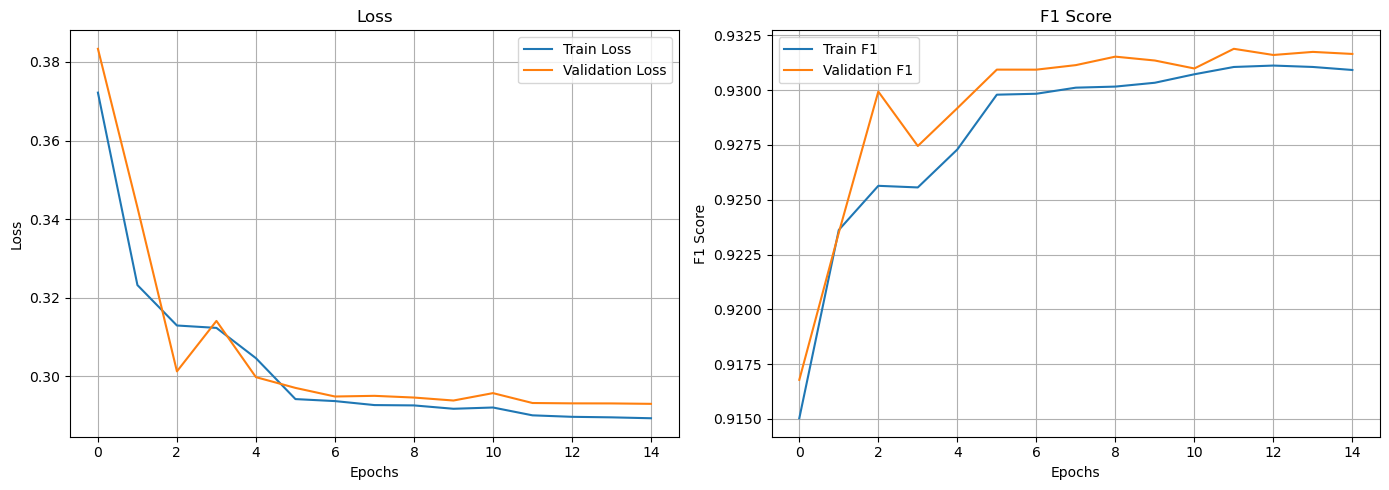

In [84]:
# Plotting the results obtained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and validation loss
axes[0].plot(model.history.history['loss'], label='Train Loss')
axes[0].plot(model.history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Plot training and validation AUC
if 'f1_score' in model.history.history:
    axes[1].plot(model.history.history['f1_score'], label='Train F1')
    axes[1].plot(model.history.history['val_f1_score'], label='Validation F1')
    axes[1].set_title('F1 Score')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1 Score')
    axes[1].legend()
    axes[1].grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()